# [Implementing Neural Networks with Numpy](https://towardsdatascience.com/math-neural-network-from-scratch-in-python-d6da9f29ce65)

## [Part 4: Neural Networks from Scratch](https://github.com/OmarAflak/Medium-Python-Neural-Network)  

In this post we will go through the mathematics of machine learning and code from scratch, in Python, a small library to build neural networks with a variety of layers (Fully Connected, Convolutional, etc.). Eventually, we will be able to create networks in a modular fashion:

#### Layer by Layer

We need to keep in mind the big picture here :

+ We feed input data into the neural network.
+ The data flows from layer to layer until we have the output.
+ Once we have the output, we can calculate the error which is a scalar.
+ Finally we can adjust a given parameter (weight or bias) by subtracting the derivative of the error with respect to the parameter itself.
    
We iterate through that process.

The most important step is the 4th. We want to be able to have as many layers as we want, and of any type. But if we modify/add/remove one layer from the network, the output of the network is going to change, which is going to change the error, which is going to change the derivative of the error with respect to the parameters. We need to be able to compute the derivatives regardless of the network architecture, regardless of the activation functions, regardless of the loss we use.

In order to achieve that, we must implement each layer separately.

### What every layer should implement

Every layer that we might create (fully connected, convolutional, maxpooling, dropout, etc.) have at least 2 things in common: input and output data.

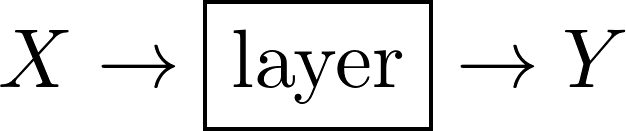

In [2]:
from IPython.display import display, Image
Image(filename='./Images/1nn.png')

### Forward propagation

We can already emphasize one important point which is: the output of one layer is the input of the next one.

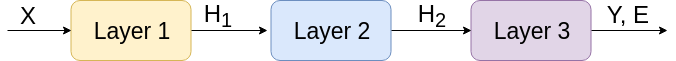

In [3]:
Image(filename='./Images/2nn.png')

This is called forward propagation. Essentially, we give the input data to the first layer, then the output of every layer becomes the input of the next layer until we reach the end of the network. By comparing the result of the network (Y) with the desired output (let’s say Y*), we can calculate en error E. The goal is to minimize that error by changing the parameters in the network. That is backward propagation (backpropagation).

### Gradient Descent

This is a quick reminder, if you need to learn more about gradient descent there are tons of resources on the internet.

Basically, we want to change some parameter in the network (call it w) so that the total error E decreases. There is a clever way to do it (not randomly) which is the following :

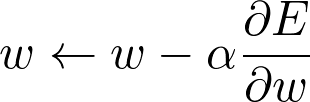

In [4]:
Image(filename='./Images/3nn.png')

Where α is a parameter in the range [0,1] that we set and that is called the learning rate. Anyway, the important thing here is ∂E/∂w (the derivative of E with respect to w). We need to be able to find the value of that expression for any parameter of the network regardless of its architecture.
Backward propagation

Suppose that we give a layer the derivative of the error with respect to its output (∂E/∂Y), then it must be able to provide the derivative of the error with respect to its input (∂E/∂X).

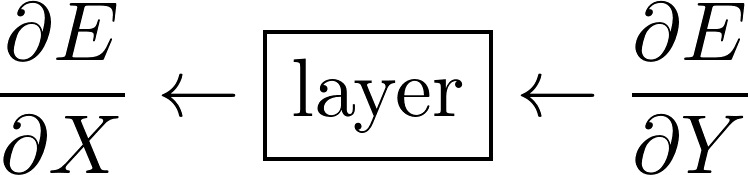

In [5]:
Image(filename='./Images/4nn.png')

Remember that E is a scalar (a number) and X and Y are matrices.

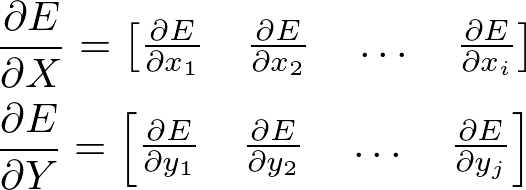

In [7]:
Image(filename='./Images/5nn.png')

Let’s forget about ∂E/∂X for now. The trick here, is that if we have access to ∂E/∂Y we can very easily calculate ∂E/∂W (if the layer has any trainable parameters) without knowing anything about the network architecture! 
We simply use the chain rule :

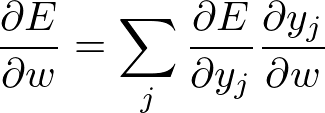

In [9]:
Image(filename='./Images/6nn.png')

The unknown is $∂y_j/∂w$ which totally depends on how the layer is computing its output. So if every layer have access to ∂E/∂Y, where Y is its own output, then we can update our parameters!

### But why ∂E/∂X ?

Don’t forget, the output of one layer is the input of the next layer. Which means ∂E/∂X for one layer is ∂E/∂Y for the previous layer!  

That’s it ! It’s just a clever way to propagate the error ! Again, we can use the chain rule :

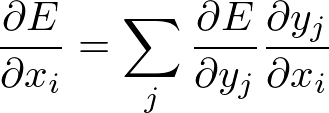

In [10]:
Image(filename='./Images/7nn.png')

This is very important, it’s the key to understand backpropagation ! After that, we’ll be able to code a Deep Convolutional Neural Network from scratch in no time !
Diagram to understand backpropagation

This is what I described earlier. Layer 3 is going to update its parameters using ∂E/∂Y, and is then going to pass ∂E/∂H2 to the previous layer, which is its own “∂E/∂Y”. Layer 2 is then going to do the same, and so on and so forth.

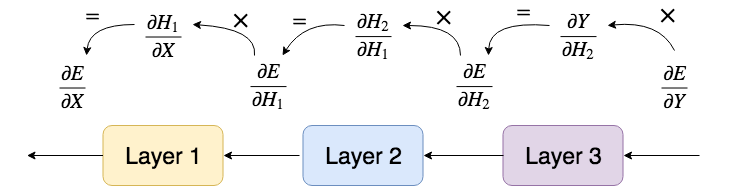

In [11]:
Image(filename='./Images/8nn.png')

This may seem abstract here, but it will get very clear when we will apply this to a specific type of layer. Speaking of abstract, now is a good time to write our first python class.

### Abstract Base Class : Layer

The abstract class Layer, which all other layers will inherit from, handles simple properties which are an input, an output, and both a forward and backward methods.

In [12]:
# Base class
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    # computes the output Y of a layer for a given input X
    def forward_propagation(self, input):
        raise NotImplementedError

    # computes dE/dX for a given dE/dY (and update parameters if any)
    def backward_propagation(self, output_error, learning_rate):
        raise NotImplementedError

As you can see there is an extra parameter in backward_propagation that I didn’t mention, it is the learning_rate. This parameter should be something like an update policy, or an optimizer as they call it in Keras, but for the sake of simplicity we’re simply going to pass a learning rate and update our parameters using gradient descent.

### Fully Connected Layer

Now let's define and implement the first type of layer: fully connected layer or FC layer. FC layers are the most basic layers as every input neurons are connected to every output neurons.

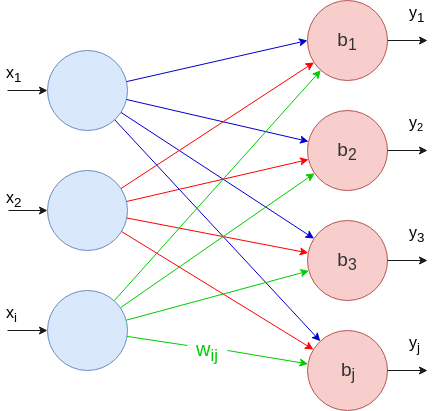

In [13]:
Image(filename='./Images/9nn.png')

### Forward Propagation

The value of each output neuron can be calculated as the following :

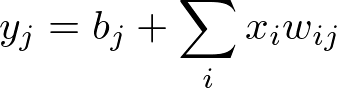

In [14]:
Image(filename='./Images/10nn.png')

With matrices, we can compute this formula for every output neuron in one shot using a dot product :

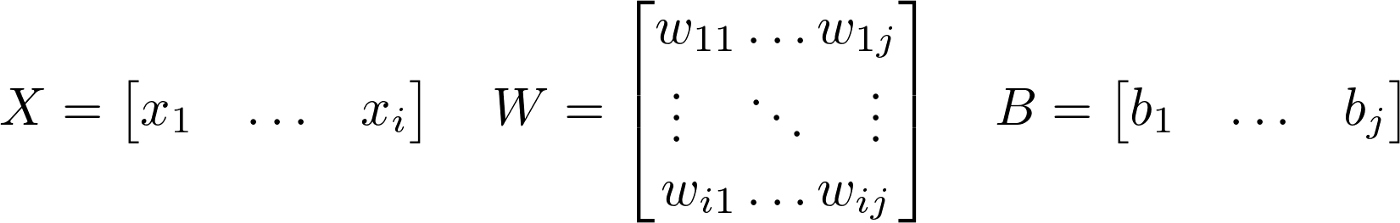

In [17]:
Image(filename='./Images/11nn.png')

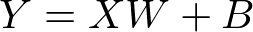

In [18]:
Image(filename='./Images/12nn.png')

We’re done with the forward pass. Now let’s do the backward pass of the FC layer.

Note that I’m not using any activation function yet, that’s because we will implement it in a separate layer!
Backward Propagation

As we said, suppose we have a matrix containing the derivative of the error with respect to that layer’s output (∂E/∂Y). We need :

+ The derivative of the error with respect to the parameters (∂E/∂W, ∂E/∂B)
+ The derivative of the error with respect to the input (∂E/∂X)

Let's calculate ∂E/∂W. This matrix should be the same size as W itself : ixj where i is the number of input neurons and j the number of output neurons.  
We need one gradient for every weight:

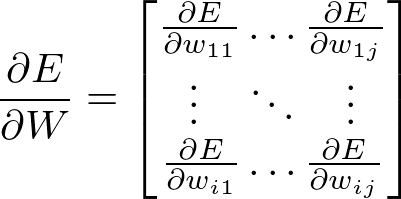

In [20]:
Image(filename='./Images/13nn.png')

Using the chain rule stated earlier, we can write :

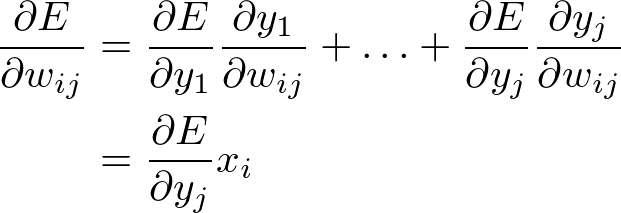

In [21]:
Image(filename='./Images/14nn.png')

Therefore,

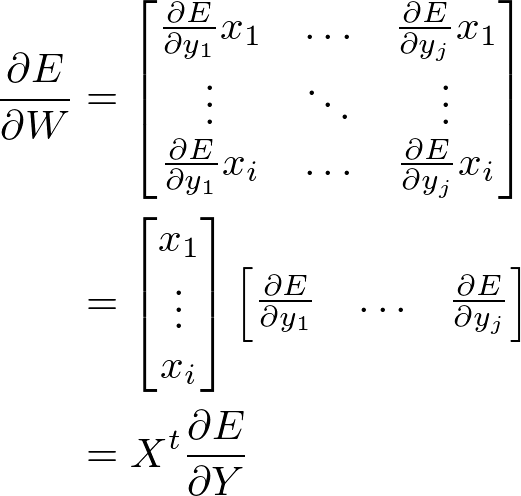

In [22]:
Image(filename='./Images/15nn.png')

That’s it we have the first formula to update the weights! Now let's calculate ∂E/∂B.

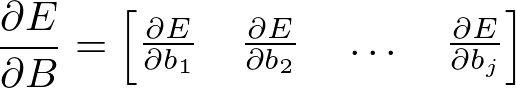

In [23]:
Image(filename='./Images/16nn.png')

Again ∂E/∂B needs to be of the same size as B itself, one gradient per bias. We can use the chain rule again :

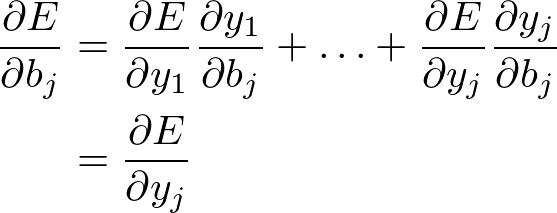

In [24]:
Image(filename='./Images/17nn.png')

And conclude that,

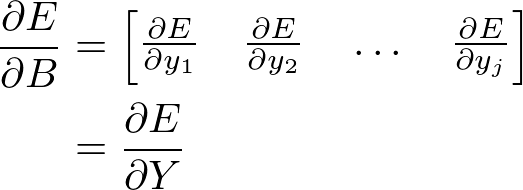

In [25]:
Image(filename='./Images/18nn.png')

Now that we have ∂E/∂W and ∂E/∂B, we are left with ∂E/∂X which is very important as it will “act” as ∂E/∂Y for the layer before that one.

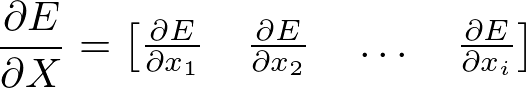

In [26]:
Image(filename='./Images/19nn.png')

Again, using the chain rule,

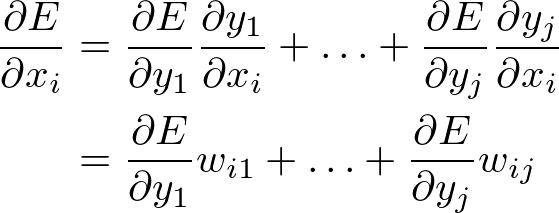

In [27]:
Image(filename='./Images/20nn.png')

Finally, we can write the whole matrix :

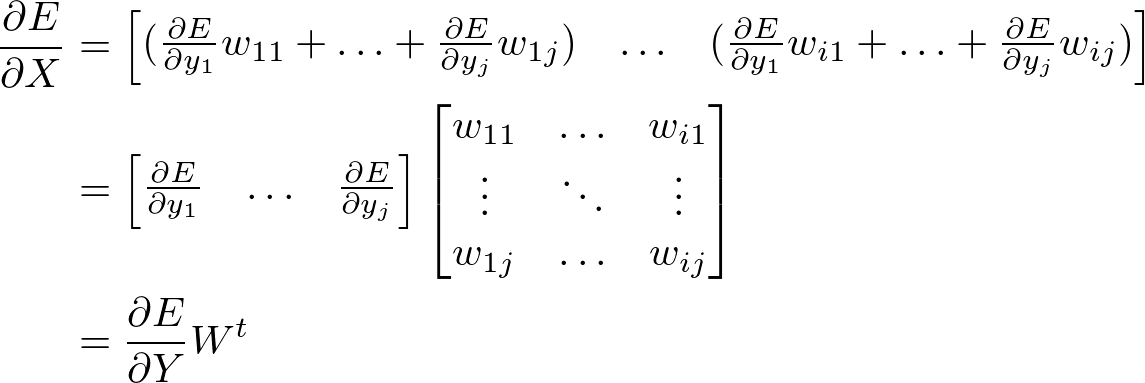

In [28]:
Image(filename='./Images/21nn.png')

That’s it! We have the three formulas we needed for the FC layer!

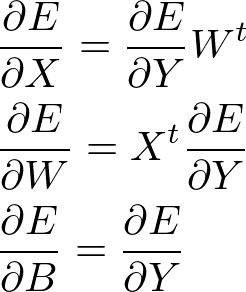

In [29]:
Image(filename='./Images/22nn.png')

Coding the Fully Connected Layer

We can now write some python code to bring this math to life!

In [30]:
import numpy as np

# inherit from base class Layer
class FCLayer(Layer):
    # input_size = number of input neurons
    # output_size = number of output neurons
    def __init__(self, input_size, output_size):
        self.weights = np.random.rand(input_size, output_size) - 0.5
        self.bias = np.random.rand(1, output_size) - 0.5

    # returns output for a given input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output

    # computes dE/dW, dE/dB for a given output_error=dE/dY. Returns input_error=dE/dX.
    def backward_propagation(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        # dBias = output_error

        # update parameters
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error

### Activation Layer

All the calculation we did until now were completely linear. It's hopeless to learn anything with that kind of model. We need to add non-linearity to the model by applying non-linear functions to the output of some layers.

Now we need to redo the whole process for this new type of layer!

No worries, it’s going to be way faster as there are no learnable parameters. We just need to calculate ∂E/∂X.

We will call f and f' the activation function and its derivative respectively.

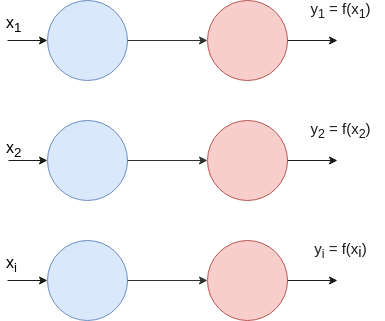

In [31]:
Image(filename='./Images/23nn.png')

### Forward Propagation

As you will see, it is quite straightforward. For a given input X , the output is simply the activation function applied to every element of X . Which means input and output have the same dimensions.

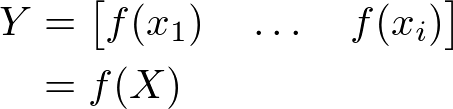

In [32]:
Image(filename='./Images/24nn.png')

### Backward Propagation

Given ∂E/∂Y, we want to calculate ∂E/∂X.

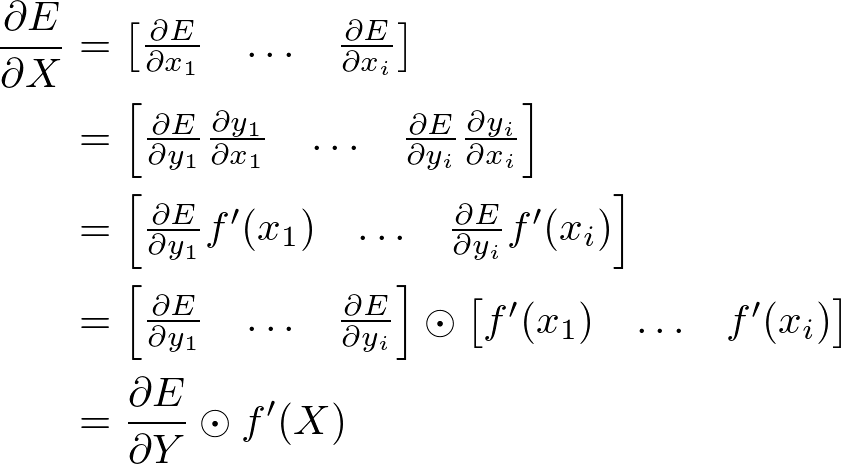

In [33]:
Image(filename='./Images/25nn.png')

Be careful, here we are using an element-wise multiplication between the two matrices (whereas in the formulas above, it was a dot product).

### Coding the Activation Layer

The code for the activation layer is as straightforward.

In [34]:
# inherit from base class Layer
class ActivationLayer(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    # returns the activated input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output

    # Returns input_error=dE/dX for a given output_error=dE/dY.
    # learning_rate is not used because there is no "learnable" parameters.
    def backward_propagation(self, output_error, learning_rate):
        return self.activation_prime(self.input) * output_error

You can also write some activation functions and their derivatives in a separate file. These will be used later to create an ActivationLayer.

In [35]:
# activation function and its derivative
def tanh(x):
    return np.tanh(x);

def tanh_prime(x):
    return 1-np.tanh(x)**2;

### Loss Function

Until now, for a given layer, we supposed that ∂E/∂Y was given (by the next layer). But what happens to the last layer? How does it get ∂E/∂Y? We simply give it manually, and it depends on how we define the error.

The error of the network, which measures how good or bad the network did for a given input data, is defined by you. There are many ways to define the error, and one of the most known is called MSE — Mean Squared Error.

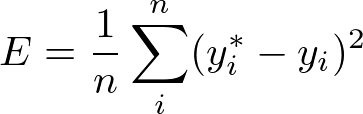

In [36]:
Image(filename='./Images/26nn.png')

Where y* and y denotes desired output and actual output respectively. You can think of the loss as a last layer which takes all the output neurons and squashes them into one single neuron. What we need now, as for every other layer, is to define ∂E/∂Y. Except now, we finally reached E !

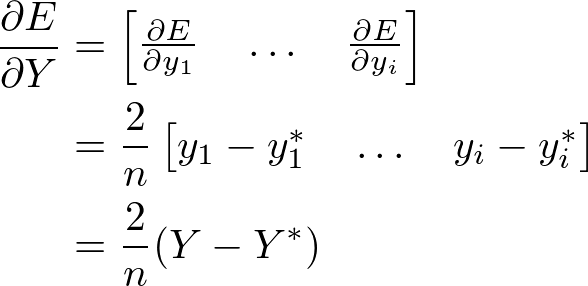

In [38]:
Image(filename='./Images/27nn.png')

These are simply two python functions that you can put in a separate file. They will be used when creating the network.

In [43]:
# loss function and its derivative
def mse(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2));

def mse_prime(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size;

Network Class

Almost done ! We are going to make a Network class to create neural networks very easily akin the first picture !

I commented almost every part of the code, it shouldn’t be too complicated to understand if you grasped the previous steps. Nevertheless, leave a comment if you have any question, I will gladly answer !

In [51]:
class Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_prime = None

    # add layer to network
    def add(self, layer):
        self.layers.append(layer)

    # set loss to use
    def use(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime

    # predict output for given input
    def predict(self, input_data):
        # sample dimension first
        samples = len(input_data)
        result = []

        # run network over all samples
        for i in range(samples):
            # forward propagation
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)

        return result

    # train the network
    
    def fit(self, x_train, y_train, epochs, learning_rate):
        # sample dimension first
        samples = len(x_train)

        # training loop
        for i in range(epochs):
            err = 0
            for j in range(samples):
                # forward propagation
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forward_propagation(output)

                # compute loss (for display purpose only)
                err += self.loss(y_train[j], output)

                # backward propagation
                error = self.loss_prime(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.backward_propagation(error, learning_rate)

            # calculate average error on all samples
            err /= samples
            if i%10==0:
                print('epoch %d/%d   error=%f' % (i+1, epochs, err))

### Building Neural Networks

Finally ! We can use our class to create a neural network with as many layers as we want ! We are going to build two neural networks : a simple XOR and a MNIST solver.

### Solve XOR

Starting with XOR is always important as it’s a simple way to tell if the network is learning anything at all.

In [52]:
### training data
x_train = np.array([[[0,0]], [[0,1]], [[1,0]], [[1,1]]])
y_train = np.array([[[0]], [[1]], [[1]], [[0]]])

# network
net = Network()
net.add(FCLayer(2, 3))
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(3, 1))
net.add(ActivationLayer(tanh, tanh_prime))

# train
net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=1000, learning_rate=0.1)

# test
out = net.predict(x_train)
print(out)

epoch 1/1000   error=0.455614
epoch 11/1000   error=0.288001
epoch 21/1000   error=0.285952
epoch 31/1000   error=0.284627
epoch 41/1000   error=0.283700
epoch 51/1000   error=0.283059
epoch 61/1000   error=0.282615
epoch 71/1000   error=0.282302
epoch 81/1000   error=0.282071
epoch 91/1000   error=0.281894
epoch 101/1000   error=0.281750
epoch 111/1000   error=0.281627
epoch 121/1000   error=0.281518
epoch 131/1000   error=0.281416
epoch 141/1000   error=0.281319
epoch 151/1000   error=0.281226
epoch 161/1000   error=0.281134
epoch 171/1000   error=0.281044
epoch 181/1000   error=0.280954
epoch 191/1000   error=0.280866
epoch 201/1000   error=0.280779
epoch 211/1000   error=0.280693
epoch 221/1000   error=0.280609
epoch 231/1000   error=0.280526
epoch 241/1000   error=0.280446
epoch 251/1000   error=0.280368
epoch 261/1000   error=0.280292
epoch 271/1000   error=0.280219
epoch 281/1000   error=0.280149
epoch 291/1000   error=0.280083
epoch 301/1000   error=0.280019
epoch 311/1000   er

Clearly this is working, great ! We can now solve something more interesting, let’s solve MNIST!

### Solve MNIST

We didn’t implemented the Convolutional Layer but this is not a problem. All we need to do is to reshape our data so that it can fit into a Fully Connected Layer.

MNIST Dataset consists of images of digits from 0 to 9, of shape 28x28x1. The goal is to predict what digit is drawn on a picture.

In [53]:
from keras.datasets import mnist
from keras.utils import np_utils

# load MNIST from server
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# training data : 60000 samples
# reshape and normalize input data
x_train = x_train.reshape(x_train.shape[0], 1, 28*28)
x_train = x_train.astype('float32')
x_train /= 255
# encode output which is a number in range [0,9] into a vector of size 10
# e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
y_train = np_utils.to_categorical(y_train)

# same for test data : 10000 samples
x_test = x_test.reshape(x_test.shape[0], 1, 28*28)
x_test = x_test.astype('float32')
x_test /= 255
y_test = np_utils.to_categorical(y_test)

# Network
net = Network()
net.add(FCLayer(28*28, 100))                # input_shape=(1, 28*28)    ;   output_shape=(1, 100)
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(100, 50))                   # input_shape=(1, 100)      ;   output_shape=(1, 50)
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(50, 10))                    # input_shape=(1, 50)       ;   output_shape=(1, 10)
net.add(ActivationLayer(tanh, tanh_prime))

# train on 1000 samples
# as we didn't implemented mini-batch GD, training will be pretty slow if we update at each iteration on 60000 samples...
net.use(mse, mse_prime)
net.fit(x_train[0:1000], y_train[0:1000], epochs=35, learning_rate=0.1)

# test on 3 samples
out = net.predict(x_test[0:3])
print("\n")
print("predicted values : ")
print(out, end="\n")
print("true values : ")
print(y_test[0:3])

epoch 1/35   error=0.239812
epoch 11/35   error=0.031687
epoch 21/35   error=0.017488
epoch 31/35   error=0.011309


predicted values : 
[array([[-0.04381517,  0.00198384, -0.15582262, -0.02400754,  0.03809747,
         0.15177495,  0.07157804,  0.91479925, -0.00917612, -0.07839883]]), array([[-1.89809861e-01, -7.25385898e-02,  9.79285639e-01,
         2.79010065e-01,  1.38597077e-01,  3.54811208e-02,
        -5.27918447e-04,  6.60673183e-02, -2.50313573e-01,
         1.46301317e-01]]), array([[-0.10049024,  0.974297  , -0.28756775, -0.06421858, -0.08516046,
         0.11630913,  0.01553693,  0.11471066, -0.12064548,  0.12435568]])]
true values : 
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


This is working perfectly ! Amazing :)